In [25]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import requests
from tqdm import tqdm
from sqlalchemy import create_engine
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import platform
import statsmodels.api as sm
import ssl
import certifi
from urllib.request import urlopen
import json
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from DATA.stock_invest_function import *
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

matplotlib.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [74]:
def load_forecast_by_hscode(db_info, root_hs_code, table_name='korea_trade_forecast_by_month'):
    """
    특정 root_hs_code에 해당하는 예측 데이터를 데이터베이스에서 불러오는 함수

    Parameters:
    - db_info (dict): DB 접속 정보 (host, port, user, password, database)
    - root_hs_code (str or int): 조회할 HS 코드
    - table_name (str): 테이블 이름 (기본값: 'trade_forecast_by_month')

    Returns:
    - pd.DataFrame: 조회된 데이터프레임
    """
    try:
        # ✅ DB 엔진 생성
        engine = create_engine(
            f"mysql+pymysql://{db_info['user']}:{db_info['password']}@{db_info['host']}:{db_info['port']}/{db_info['database']}"
        )

        # ✅ SQL 쿼리 작성 및 실행
        query = f"""
            SELECT *
            FROM {table_name}
            WHERE root_hs_code = '{root_hs_code}'
            ORDER BY date
        """
        df = pd.read_sql(query, con=engine)

        print(f"✅ root_hs_code={root_hs_code}에 해당하는 {len(df)}개 행을 불러왔습니다.")
        return df

    except Exception as e:
        print(f"❌ 데이터 불러오기 실패: {e}")
        return pd.DataFrame()

def get_quarterly_export_forecast(db_info: dict, hs_code: str) -> pd.DataFrame:
    """
    특정 HS 코드를 기준으로 수출 예측 데이터를 불러와 분기별로 정리하는 함수

    Parameters:
    - db_info: dict, MariaDB 접속 정보
    - hs_code: str, 예: '854232' (HS 코드)

    Returns:
    - quarterly_sum_df: DataFrame, 분기별 수출합계 및 qoq/yoy 증가율 포함
    """
    # DB에서 해당 HS코드의 예측 데이터 로드
    target_export_df = load_forecast_by_hscode(db_info, hs_code)
    temp_df = load_forecast_by_hscode(db_info, '854232', table_name='korea_trade_forecast_by_month')

    # 중복 제거
    target_export_df = temp_df.drop_duplicates(subset=['date'])

    # date를 datetime으로 변환
    target_export_df['date'] = pd.to_datetime(target_export_df['date'])

    # 분기 추출 및 그룹화
    target_export_df['quarter'] = target_export_df['date'].dt.to_period('Q')
    quarterly_sum_df = target_export_df.groupby('quarter')['expDlr_forecast_12m'].sum().reset_index()

    # datetime 변환 후 추가 계산
    quarterly_sum_df['quarter'] = quarterly_sum_df['quarter'].dt.to_timestamp()
    quarterly_sum_df['export_qoq_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=1)
    quarterly_sum_df['export_yoy_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=4)
    quarterly_sum_df['date_month'] = quarterly_sum_df['quarter'] + pd.offsets.QuarterEnd(0)

    return quarterly_sum_df


def merge_endog_exog_data(endog_df, exog_df,
                          endog_col, exog_col,
                          start_date=None, end_date=None):
    """
    두 데이터프레임에서 지정한 칼럼을 추출하고 날짜 기준으로 병합합니다.
    """

    # 1. 복사 및 날짜 처리
    endog_df = endog_df.copy()
    exog_df = exog_df.copy()

    # 날짜 → 분기 종료일 → 시간 정보 제거
    # 날짜 → 분기 종료일 → 시간 제거
    endog_df['date'] = pd.to_datetime(endog_df['date']).dt.to_period('Q').dt.to_timestamp(how='end').dt.normalize()
    exog_df['date'] = pd.to_datetime(exog_df['date']).dt.to_period('Q').dt.to_timestamp(how='end').dt.normalize()

    # 2. 외생변수는 중복 제거
    exog_df = exog_df.groupby('date')[exog_col].last().reset_index()

    # 3. 날짜 필터링
    if start_date:
        start = pd.to_datetime(start_date)
        endog_df = endog_df[endog_df['date'] >= start]
        exog_df = exog_df[exog_df['date'] >= start]
    if end_date:
        end = pd.to_datetime(end_date)
        endog_df = endog_df[endog_df['date'] <= end]
        exog_df = exog_df[exog_df['date'] <= end]

    # 4. 필요한 칼럼 추출
    endog_df = endog_df[['date', endog_col]]
    exog_df = exog_df[['date', exog_col]]

    # 5. 병합
    merged_df = pd.merge(endog_df, exog_df, on='date', how='inner')

    # 6. 열 이름 변경
    merged_df.rename(columns={
        endog_col: 'endog_var',
        exog_col: 'exog_var'
    }, inplace=True)

    return merged_df

def sarima_forecast_with_log_option(df, date_col='date', value_col='endog_var', use_log=1):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from sklearn.metrics import mean_absolute_error
    import matplotlib.pyplot as plt
    import numpy as np
    from itertools import product
    import pandas as pd

    # ✅ 1. 중복 제거: 같은 날짜가 여러 행에 있을 경우 마지막 값만 사용
    df_clean = df.groupby(date_col)[value_col].last().reset_index()

    # ✅ 2. 시계열로 변환
    ts = df_clean.set_index(date_col)[value_col].asfreq('Q')

    # ✅ 3. 로그 변환
    if use_log:
        ts = np.log(ts)
        print("✅ 로그 변환 적용")

    # 4. Train/Test 분리
    train = ts.iloc[:-4]
    test = ts.iloc[-4:]

    # 5. SARIMA 파라미터 탐색
    p = d = q = P = D = Q = [0, 1]
    s = 4
    param_combinations = list(product(p, d, q))
    seasonal_combinations = list(product(P, D, Q))
    total_combinations = list(product(param_combinations, seasonal_combinations))

    best_aic = np.inf
    best_model = None
    best_order = None
    best_seasonal = None

    print(f"🔍 총 {len(total_combinations)}개의 SARIMA 조합 평가 중...")

    for (order, seasonal) in total_combinations:
        seasonal_order = (*seasonal, s)
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = result
        except:
            continue

    print(f"\n✅ 최적 SARIMA 구조: order={best_order}, seasonal_order={best_seasonal}, AIC={best_aic:.2f}")

    # 6. 예측
    forecast_log = best_model.forecast(steps=4)
    forecast = np.exp(forecast_log) if use_log else forecast_log
    test_true = np.exp(test) if use_log else test

    # 7. MAE
    mae = mean_absolute_error(test_true, forecast)
    print(f"📉 OOS MAE (최근 4분기): {mae:.2f}")

    # 8. 잔차 분석
    residuals = best_model.resid
    print("\n📊 Ljung-Box Test (잔차의 자기상관 여부):")
    print(acorr_ljungbox(residuals, lags=[4, 8, 12], return_df=True))

    # 9. 잔차 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1); plt.plot(residuals); plt.title("잔차 시계열")
    plt.subplot(2, 2, 2); plot_acf(residuals, ax=plt.gca(), lags=20); plt.title("잔차 ACF")
    plt.subplot(2, 2, 3); plot_pacf(residuals, ax=plt.gca(), lags=20); plt.title("잔차 PACF")
    plt.subplot(2, 2, 4); plt.hist(residuals, bins=20); plt.title("잔차 분포")
    plt.tight_layout(); plt.show()

    # 10. 전체 시계열 시각화
    ts_all = np.exp(ts) if use_log else ts
    plt.figure(figsize=(10, 4))
    plt.plot(ts_all, label='실제값')
    plt.plot(forecast.index, forecast, label='예측값 (OOS)', linestyle='--', marker='o')
    plt.legend(); plt.title("최근 4분기 예측 vs 실제"); plt.grid(True); plt.show()

    return forecast

def forecast_future_4q_with_sarima(df, date_col='date', value_col='endog_var', use_log=True):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    import matplotlib.pyplot as plt
    from itertools import product
    import numpy as np

    # 시계열로 변환
    ts = df.set_index(date_col)[value_col].asfreq('Q')

    if use_log:
        ts_transformed = np.log(ts)
        print("✅ 로그 변환 적용")
    else:
        ts_transformed = ts

    # Grid search
    p = d = q = P = D = Q = [0, 1]
    s = 4
    param_combinations = list(product(p, d, q))
    seasonal_combinations = list(product(P, D, Q))
    total_combinations = list(product(param_combinations, seasonal_combinations))

    best_aic = np.inf
    best_model = None
    best_order = None
    best_seasonal = None

    print(f"🔍 총 {len(total_combinations)}개의 SARIMA 조합 평가 중...")

    for (order, seasonal) in tqdm(total_combinations):
        seasonal_order = (*seasonal, s)
        try:
            model = SARIMAX(ts_transformed, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = result
        except:
            continue

    print(f"\n✅ 최적 SARIMA 구조: order={best_order}, seasonal_order={best_seasonal}, AIC={best_aic:.2f}")

    # 미래 4분기 예측
    forecast_log = best_model.forecast(steps=4)

    if use_log:
        forecast = np.exp(forecast_log)
    else:
        forecast = forecast_log

    # 결과 출력
    print("\n📈 미래 4분기 예측 결과:")
    print(forecast)

    # 시각화
    if use_log:
        ts_all = np.exp(ts)
    else:
        ts_all = ts

    plt.figure(figsize=(10, 4))
    plt.plot(ts_all, label='실제값')
    plt.plot(forecast.index, forecast, label='예측값 (미래 4분기)', linestyle='--', marker='o')
    plt.legend()
    plt.title("전체 데이터로 학습한 미래 4분기 예측")
    plt.grid(True)
    plt.show()

    return forecast

def forecast_with_exog_sarimax(df, future_exog, date_col='date', endog_col='endog_var', exog_col='exog_var', use_log=True):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from itertools import product
    from tqdm import tqdm

    # 1. 시계열 설정
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df = df.asfreq('Q')
    ts = df[endog_col]
    exog = df[exog_col]

    if use_log:
        ts_transformed = np.log(ts)
        print("✅ 로그 변환 적용")
    else:
        ts_transformed = ts

    # 2. Grid Search 설정
    p = d = q = P = D = Q = [0, 1]
    s = 4
    param_combinations = list(product(p, d, q))
    seasonal_combinations = list(product(P, D, Q))
    total_combinations = list(product(param_combinations, seasonal_combinations))

    best_aic = np.inf
    best_model = None
    best_order = None
    best_seasonal = None

    print(f"🔍 총 {len(total_combinations)}개의 SARIMAX 조합 평가 중...")

    for (order, seasonal) in tqdm(total_combinations):
        seasonal_order = (*seasonal, s)
        try:
            model = SARIMAX(ts_transformed, exog=exog, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = result
        except:
            continue

    print(f"\n✅ 최적 구조: order={best_order}, seasonal_order={best_seasonal}, AIC={best_aic:.2f}")

    # 3. 향후 외생변수 준비
    future_exog = np.array(future_exog).reshape(-1, 1)

    # 4. 예측
    forecast_log = best_model.forecast(steps=4, exog=future_exog)
    forecast = np.exp(forecast_log) if use_log else forecast_log

    # 5. 잔차 분석 시각화
    residuals = best_model.resid

    print("\n📊 Ljung-Box Test (잔차의 자기상관 여부):")
    print(acorr_ljungbox(residuals, lags=[4, 8, 12], return_df=True))

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(residuals)
    plt.title("잔차 시계열")

    plt.subplot(2, 2, 2)
    plot_acf(residuals, ax=plt.gca(), lags=20)
    plt.title("잔차 ACF")

    plt.subplot(2, 2, 3)
    plot_pacf(residuals, ax=plt.gca(), lags=20)
    plt.title("잔차 PACF")

    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=20)
    plt.title("잔차 분포")

    plt.tight_layout()
    plt.show()

    # 6. 시계열 + 예측 시각화
    ts_plot = np.exp(ts) if use_log else ts
    future_index = pd.date_range(start=ts_plot.index[-1] + pd.offsets.QuarterEnd(), periods=4, freq='Q')

    plt.figure(figsize=(10, 4))
    plt.plot(ts_plot, label='실제값')
    plt.plot(future_index, forecast, label='예측값 (미래)', linestyle='--', marker='o')
    plt.title("SARIMAX 예측 결과 (외생변수 포함)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 7. 결과 반환
    forecast_df = pd.DataFrame({
        'date': future_index,
        'forecast': forecast
    }).set_index('date')

    return forecast_df


In [145]:
save_path = r"C:\Users\MetaM\PycharmProjects\stock_forecast\DATA"

tic_name = 'A005930'
st_date = '2010-01-01'
end_date = '2025-03-31'

In [146]:
# DB 접속 정보 설정
db_info = {
    'user': 'stox7412',         # 예: 'root'
    'password': 'Apt106503!~', # 예: '1234'
    'host': '192.168.0.230',
    # 'host': 'hystox74.synology.me',         # 예: 'localhost' 또는 IP
    'port': '3307',              # 기본 포트는 보통 3306
    'database': 'investar'        # 예: 'trade_data'
}

fs_df = fetch_table_data(db_info, "Korea_FS_data")
fs_df.rename(columns={'Date': 'date'}, inplace=True)

# 1. indicator 필터링
target_indicator = '매출액(천원)'
filtered_df = fs_df[fs_df['indicator'] == target_indicator].copy()

# 2. 날짜 정제 및 정렬
filtered_df['date'] = pd.to_datetime(filtered_df['date'])
filtered_df.sort_values(by='date', inplace=True)

# 3. value 컬럼이 있는지 확인 및 타입 강제
if 'value' not in filtered_df.columns:
    raise KeyError("'value' 컬럼이 없습니다.")

filtered_df['value'] = pd.to_numeric(filtered_df['value'], errors='coerce')

# 4. 피벗 테이블 생성 (행: date, 열: Symbol, 값: value)
pivot_df = filtered_df.pivot_table(
    index='date',
    columns='Symbol',
    values='value',
    aggfunc='first'  # 중복 방지
)

# 5. 전년 동분기 대비 변화율 계산 (4분기 전 대비)
fs_yoy_growth_df = pivot_df.pct_change(periods=4) * 100

✅ 'Korea_FS_data' 테이블에서 537251건의 데이터를 가져왔습니다.


In [147]:
endog_df = pivot_df[[tic_name]].reset_index()

In [121]:
temp_df = load_forecast_by_hscode(db_info, '840510', table_name='korea_trade_forecast_by_month')

# 중복 제거
target_export_df = temp_df.drop_duplicates(subset=['date'])

# date를 datetime으로 변환
target_export_df['date'] = pd.to_datetime(target_export_df['date'])

# 분기 추출 및 그룹화
target_export_df['quarter'] = target_export_df['date'].dt.to_period('Q')
quarterly_sum_df = target_export_df.groupby('quarter')['expDlr_forecast_12m'].sum().reset_index()

# datetime 변환 후 추가 계산
quarterly_sum_df['quarter'] = quarterly_sum_df['quarter'].dt.to_timestamp()
quarterly_sum_df['export_qoq_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=1)
quarterly_sum_df['export_yoy_change'] = quarterly_sum_df['expDlr_forecast_12m'].pct_change(periods=4)
quarterly_sum_df['date_month'] = quarterly_sum_df['quarter'] + pd.offsets.QuarterEnd(0)

✅ root_hs_code=840510에 해당하는 234개 행을 불러왔습니다.


In [148]:
## 수출 데이터를 불러온다

quarterly_sum_df = get_quarterly_export_forecast(db_info, '854232')
quarterly_sum_df['date'] = pd.to_datetime(quarterly_sum_df['date_month'])

# 3. date를 인덱스로 설정
quarterly_sum_df.set_index('date', inplace=True)

# ✅ (선택적으로 quarter 컬럼 제거)
quarterly_sum_df.drop(columns='quarter', inplace=True)

quarterly_sum_df = quarterly_sum_df.reset_index()

✅ root_hs_code=854232에 해당하는 234개 행을 불러왔습니다.
✅ root_hs_code=854232에 해당하는 234개 행을 불러왔습니다.


In [149]:
merged = merge_endog_exog_data(
    endog_df= endog_df,
    exog_df= quarterly_sum_df,
    endog_col=tic_name,
    exog_col='export_yoy_change',
    start_date='2010-01-01',
    end_date='2025-03-31'
)

merged

,date,endog_var,exog_var
0,2010-03-31,3.463807e+10,1.518975
1,2010-06-30,3.789192e+10,1.169630
2,2010-09-30,4.022926e+10,0.894740
3,2010-12-31,4.187108e+10,0.213980
4,2011-03-31,3.698502e+10,0.142430
...,...,...,...
56,2024-03-31,7.191560e+10,0.750191
57,2024-06-30,7.406830e+10,0.825270
58,2024-09-30,7.909873e+10,0.699102
59,2024-12-31,7.578827e+10,0.508935


🔍 총 64개의 SARIMA 조합 평가 중...

✅ 최적 SARIMA 구조: order=(0, 1, 0), seasonal_order=(0, 1, 1, 4), AIC=2470.94
📉 OOS MAE (최근 4분기): 3476950736.88

📊 Ljung-Box Test (잔차의 자기상관 여부):
     lb_stat  lb_pvalue
4   5.663308   0.225743
8   6.389255   0.603716
12  7.350074   0.833639


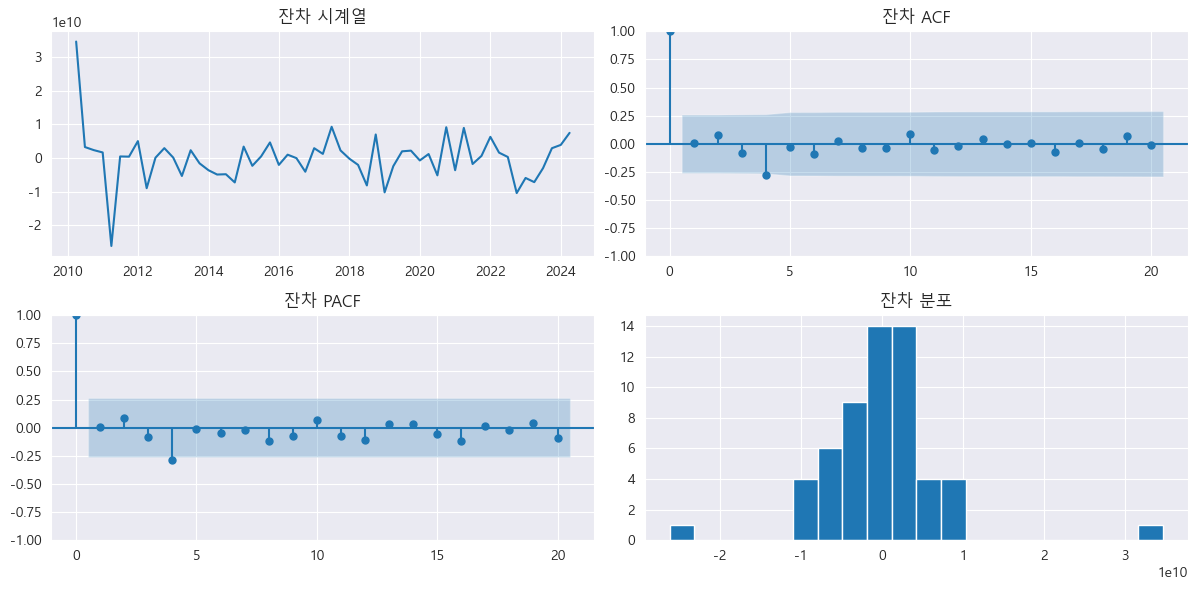

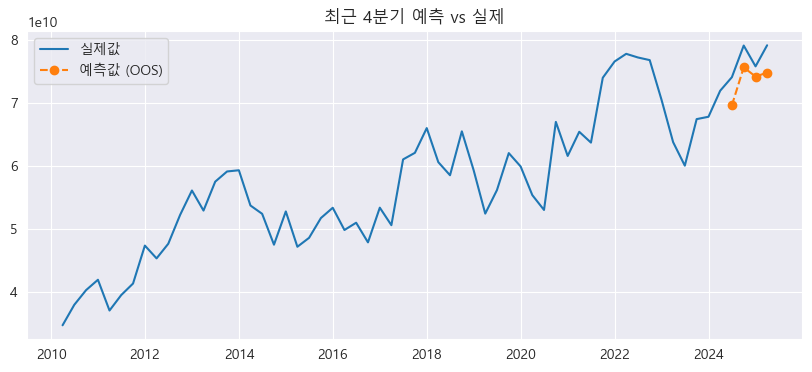

In [150]:
forecast_result = sarima_forecast_with_log_option(merged, use_log=0)

🔍 총 64개의 SARIMA 조합 평가 중...


100%|██████████| 64/64 [00:02<00:00, 30.86it/s]



✅ 최적 SARIMA 구조: order=(0, 1, 0), seasonal_order=(0, 1, 1, 4), AIC=2657.74

📈 미래 4분기 예측 결과:
2025-06-30    7.917692e+10
2025-09-30    8.468424e+10
2025-12-31    8.225050e+10
2026-03-31    8.429128e+10
Freq: QE-DEC, Name: predicted_mean, dtype: float64


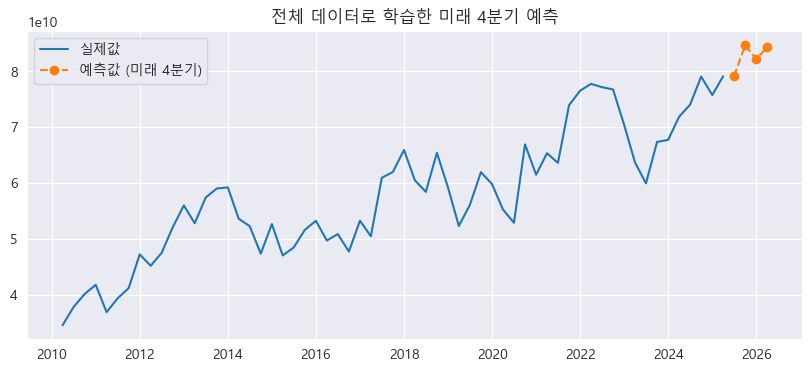

In [151]:
orecast_result = forecast_future_4q_with_sarima(merged, date_col='date', value_col='endog_var', use_log=False)

In [152]:
merged_exog = merge_endog_exog_data(
    endog_df = endog_df,
    exog_df = quarterly_sum_df,
    endog_col=tic_name,
    exog_col='export_yoy_change',
    start_date='2010-01-01',
    end_date='2026-06-30'
)

merged_exog.tail(10)

,date,endog_var,exog_var
51,2022-12-31,7.046458e+10,-0.433869
52,2023-03-31,6.374537e+10,-0.498379
53,2023-06-30,6.000553e+10,-0.455328
54,2023-09-30,6.740465e+10,-0.290891
55,2023-12-31,6.777994e+10,0.233776
56,2024-03-31,7.191560e+10,0.750191
57,2024-06-30,7.406830e+10,0.825270
58,2024-09-30,7.909873e+10,0.699102
59,2024-12-31,7.578827e+10,0.508935
60,2025-03-31,7.914050e+10,0.045684


In [153]:
future_exog_values = quarterly_sum_df[(quarterly_sum_df['date'] >= '2025-06') & (quarterly_sum_df['date'] <= '2026-06')]['export_yoy_change'].tolist()

🔍 총 64개의 SARIMAX 조합 평가 중...


100%|██████████| 64/64 [00:02<00:00, 27.28it/s]



✅ 최적 구조: order=(0, 1, 0), seasonal_order=(0, 1, 1, 4), AIC=2648.53

📊 Ljung-Box Test (잔차의 자기상관 여부):
     lb_stat  lb_pvalue
4   4.643087   0.325917
8   5.430213   0.710759
12  8.148528   0.773418


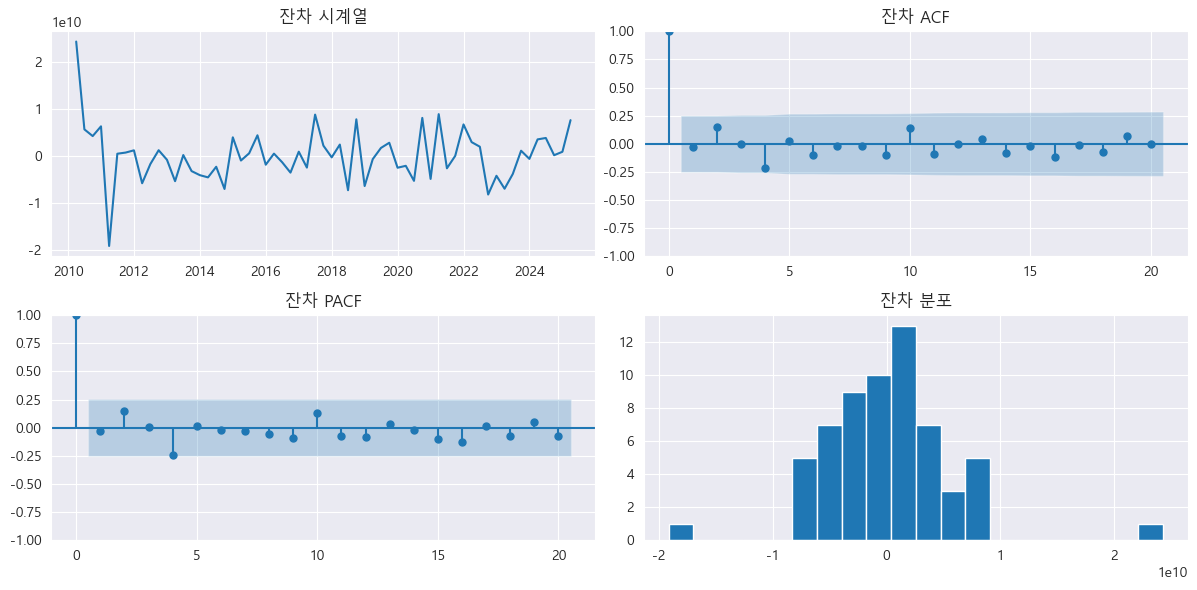

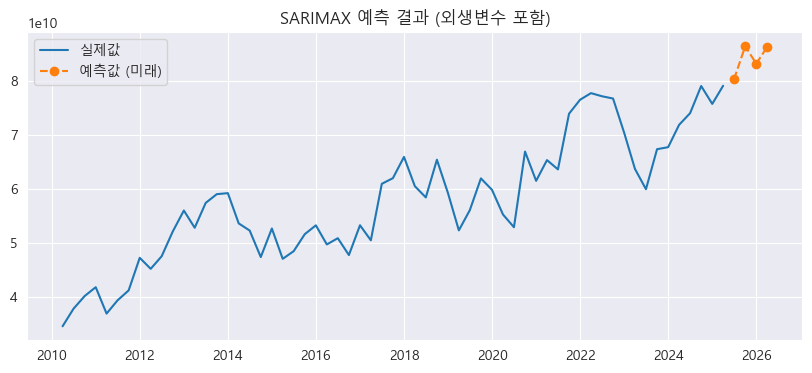

                forecast
date                    
2025-06-30  8.037944e+10
2025-09-30  8.645118e+10
2025-12-31  8.323163e+10
2026-03-31  8.629946e+10


In [154]:
forecast_result = forecast_with_exog_sarimax(merged, future_exog=future_exog_values, use_log=False)
print(forecast_result)